# Stap 2: Unsupervised Learning

#### Importeren van packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition
from sklearn import cluster
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram,linkage
import hdbscan
from scipy.spatial.distance import cdist, pdist

#### Instellen van pad voor data toegang

In [2]:
%cd C:\Users\mark_\source\repos\Erasmus\Bedbezetting
    
pad=%pwd

C:\Users\mark_\source\repos\Erasmus\Bedbezetting


#### Inlezen van data

In [3]:
df=pd.read_excel(pad+'\\data_clustering.xlsx')
df['Spcm'] = df.Spcm.str.split(' ').str[0]

#### Integer and one-hot encoding

In [4]:
#Sources:
#https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
#https://datascience.stackexchange.com/questions/6508/k-means-incoherent-behaviour-choosing-k-with-elbow-method-bic-variance-explain
#https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/cluster-k-means/before-you-start/overview/
   
# De clustering vindt apart plaats voor klinisch niet-spoed en spoed 
klinisch_spoed = df[(df['Opnametype']!='Dagverpleging') & (df['Spoedopname Ind']=='J')]
drop_klinisch_spoed=['Opname Datum','Opname Tijd','Ontslag Datum','Ontslag Tijd', 'id','Spoedopname Ind', 'Weekdag_ontslag_datum']
klinisch_spoed = klinisch_spoed.drop(drop_klinisch_spoed,axis=1)
klinisch_spoed.reset_index(drop=True,inplace=True)
lijst_categorical_spoed = ['Geslacht','Opnametype', 'Spcm','Spcm Herkomst', 'Weekdag_opname_datum', 'Diagnose Code', 'Icd10 Code']

#In de volgende regels worden de kolommen verwijderd uit de dataframes die niet meegenomen worden in de clustering. Aanpassen kan hier.
klinisch_nietspoed = df[(df['Opnametype']!='Dagverpleging') & (df['Spoedopname Ind']=='N')]
drop_klinisch_nietspoed=['Opname Datum','Opname Tijd','Ontslag Datum','Ontslag Tijd', 'id','Spoedopname Ind', 'Weekdag_ontslag_datum']
klinisch_nietspoed = klinisch_nietspoed.drop(drop_klinisch_nietspoed,axis=1)
klinisch_nietspoed.reset_index(drop=True,inplace=True)
lijst_categorical_nietspoed = ['Geslacht','Opnametype', 'Spcm','Spcm Herkomst', 'Weekdag_opname_datum', 'Diagnose Code', 'Icd10 Code']

In [5]:
# One hot encoding
onehot_klinisch_spoed=klinisch_spoed.copy()
onehot_klinisch_spoed=pd.get_dummies(onehot_klinisch_spoed,prefix_sep="_", columns=lijst_categorical_spoed)

onehot_klinisch_nietspoed=klinisch_nietspoed.copy()
onehot_klinisch_nietspoed=pd.get_dummies(onehot_klinisch_nietspoed,prefix_sep="_", columns=lijst_categorical_nietspoed)

#### MinMax scaling van geboortejaar & opnameduur

In [6]:
scaler_spoed=MinMaxScaler()
onehot_klinisch_spoed=scaler_spoed.fit_transform(onehot_klinisch_spoed)

scaler_nietspoed=MinMaxScaler()
onehot_klinisch_nietspoed=scaler_nietspoed.fit_transform(onehot_klinisch_nietspoed)

#### Elbow functie om te bepalen hoeveel clusters optimaal zijn + clustering results grafiek

In [7]:
def elbow(input_data,naam):
    #K is de range van clusters om uit te proberen om te kijken hoeveel clusters het best werken.
    K = range(1,50)
    KM = [cluster.KMeans(n_clusters=k).fit(input_data) for k in K]
    centroids = [k.cluster_centers_ for k in KM]

    D_k = [cdist(input_data, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/input_data.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(input_data)**2)/input_data.shape[0]
    bss = tss-wcss

    kIdx = 2

    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering '+ naam)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow fors KMeans clustering '+naam)
    plt.show()

    return

In [8]:
def plaatjes(data,onehot_encoding,algoritme):
    color=data[algoritme]
    pca = decomposition.TruncatedSVD(n_components=2)
    X_pca = pca.fit_transform(onehot_encoding)
    
    fig0 = plt.figure(figsize=(7, 7))
    ax = fig0.add_subplot(111)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=color, cmap=plt.cm.Spectral)
    
    #plt.figure()
    #g = sns.pairplot(data,hue=algoritme)

    plt.figure()
    b=sns.boxplot(x=algoritme, y="Opname_duur", data=data)
    plt.show()

    return

#### Clustering Klinisch Spoed (K-means, Spectral Clustering, Agglomerative en DBC Scan)

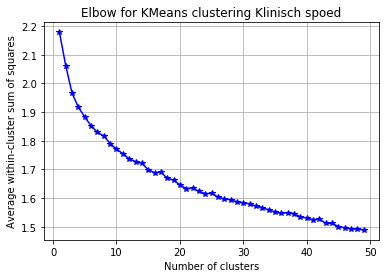

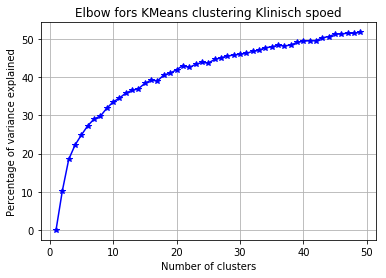

In [9]:
elbow(onehot_klinisch_spoed,'Klinisch spoed')

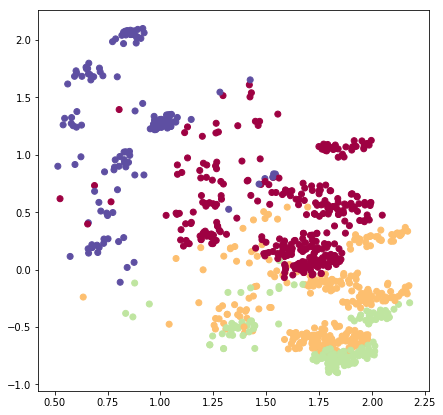

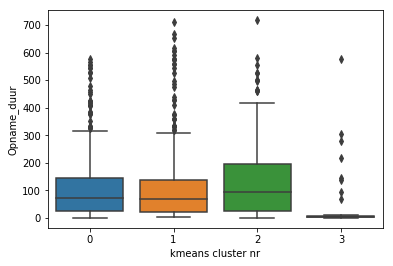

In [38]:
#K-Means
kmeans_klinisch_spoed = cluster.KMeans(n_clusters=4, random_state=0).fit(onehot_klinisch_spoed)
klinisch_spoed['kmeans cluster nr']=kmeans_klinisch_spoed.labels_
plaatjes(klinisch_spoed,onehot_klinisch_spoed,'kmeans cluster nr')

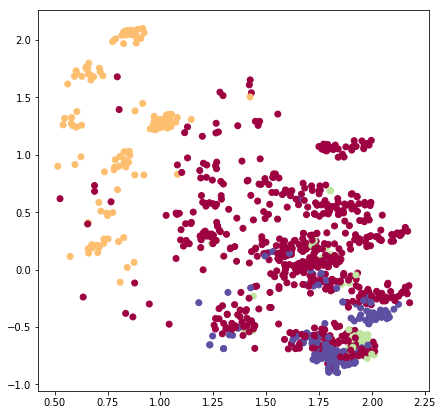

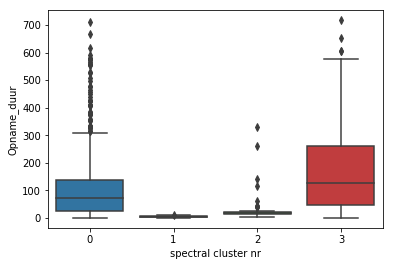

In [39]:
#Sepctral Clustering
spectral_klinisch_spoed = cluster.SpectralClustering(n_clusters=4,affinity='nearest_neighbors').fit(onehot_klinisch_spoed)
klinisch_spoed['spectral cluster nr']=spectral_klinisch_spoed.labels_
plaatjes(klinisch_spoed,onehot_klinisch_spoed,'spectral cluster nr')

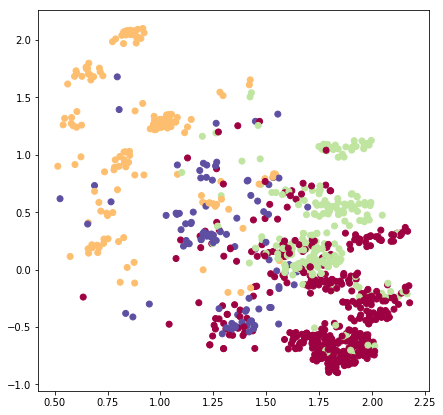

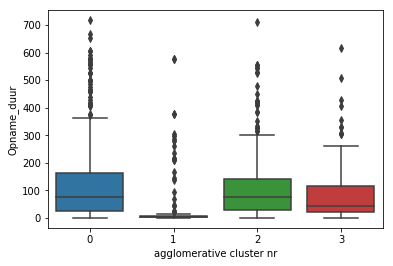

In [40]:
#Agglomerative clustering
aggl_klinisch_spoed = cluster.AgglomerativeClustering(n_clusters=4).fit(onehot_klinisch_spoed)
klinisch_spoed['agglomerative cluster nr']=aggl_klinisch_spoed.labels_
plaatjes(klinisch_spoed,onehot_klinisch_spoed,'agglomerative cluster nr')

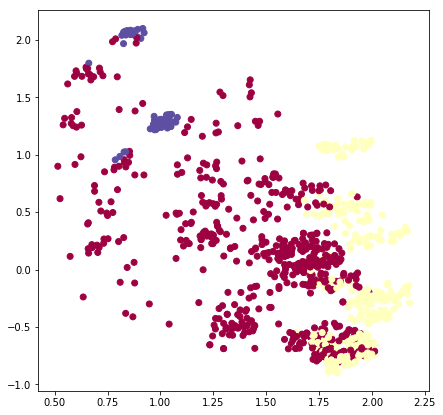

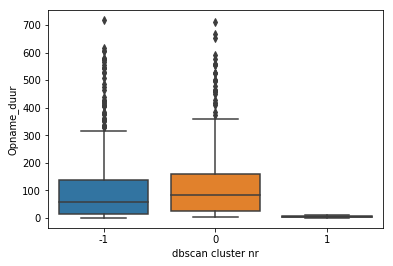

In [13]:
#DBC scan
dbscan_klinisch_spoed = hdbscan.HDBSCAN(min_cluster_size=40).fit(onehot_klinisch_spoed)
klinisch_spoed['dbscan cluster nr']=dbscan_klinisch_spoed.labels_
plaatjes(klinisch_spoed,onehot_klinisch_spoed,'dbscan cluster nr')

#### Clustering Klinisch Niet-Spoed (K-means, Spectral Clustering, Agglomerative en DBC Scan)

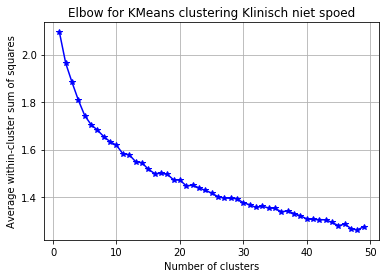

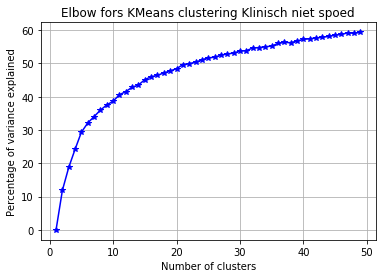

In [14]:
elbow(onehot_klinisch_nietspoed,'Klinisch niet spoed')

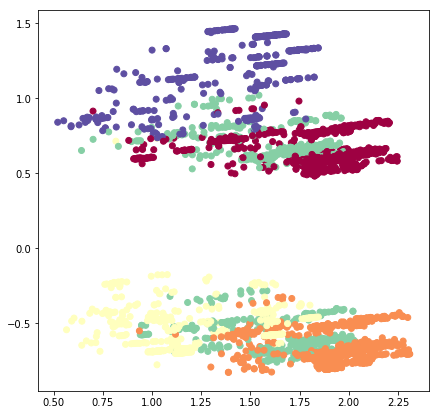

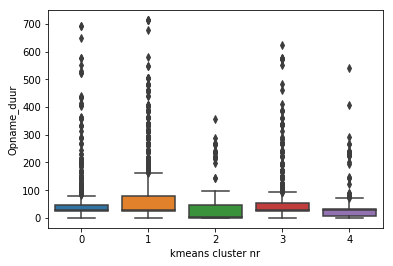

In [27]:
#K-Means
kmeans_klinisch_nietspoed = cluster.KMeans(n_clusters=5, random_state=0).fit(onehot_klinisch_nietspoed)
klinisch_nietspoed['kmeans cluster nr']=kmeans_klinisch_nietspoed.labels_
plaatjes(klinisch_nietspoed,onehot_klinisch_nietspoed,'kmeans cluster nr')

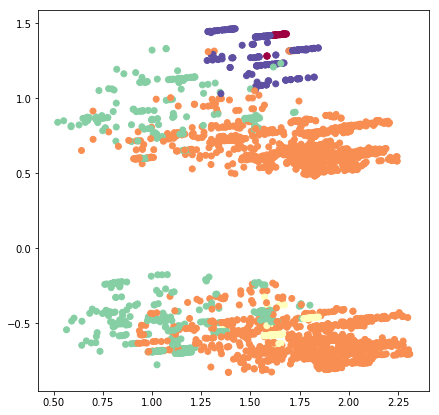

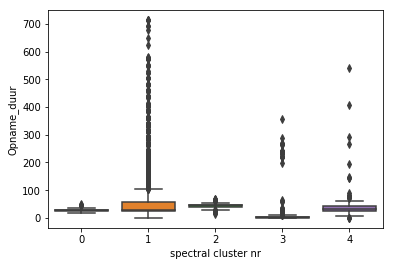

In [16]:
#Sepctral Clustering
spectral_klinisch_nietspoed = cluster.SpectralClustering(n_clusters=5,affinity='nearest_neighbors').fit(onehot_klinisch_nietspoed)
klinisch_nietspoed['spectral cluster nr']=spectral_klinisch_nietspoed.labels_
plaatjes(klinisch_nietspoed,onehot_klinisch_nietspoed,'spectral cluster nr')

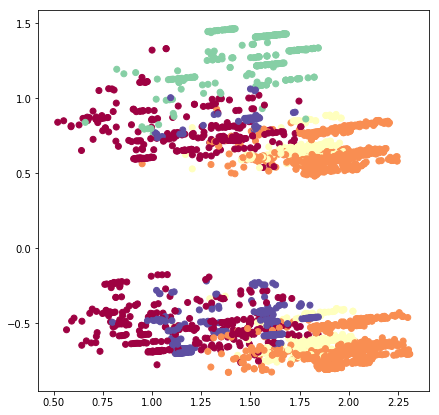

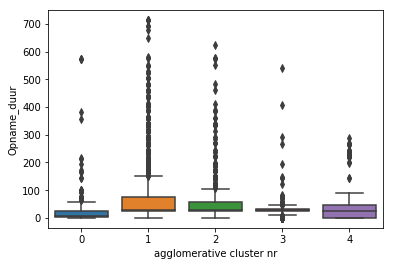

In [17]:
#Agglomerative clustering
aggl_klinisch_nietspoed = cluster.AgglomerativeClustering(n_clusters=5).fit(onehot_klinisch_nietspoed)
klinisch_nietspoed['agglomerative cluster nr']=aggl_klinisch_nietspoed.labels_
plaatjes(klinisch_nietspoed,onehot_klinisch_nietspoed,'agglomerative cluster nr')

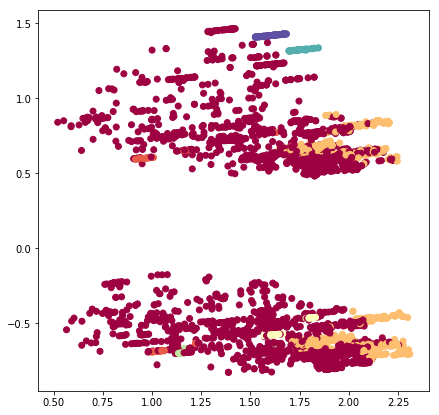

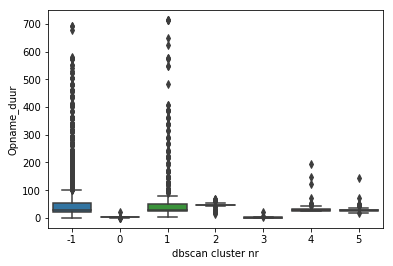

In [28]:
#DBC scan
dbscan_klinisch_nietspoed = hdbscan.HDBSCAN(min_cluster_size=50).fit(onehot_klinisch_nietspoed)
klinisch_nietspoed['dbscan cluster nr']=dbscan_klinisch_nietspoed.labels_
plaatjes(klinisch_nietspoed,onehot_klinisch_nietspoed,'dbscan cluster nr')

#### Dendogram

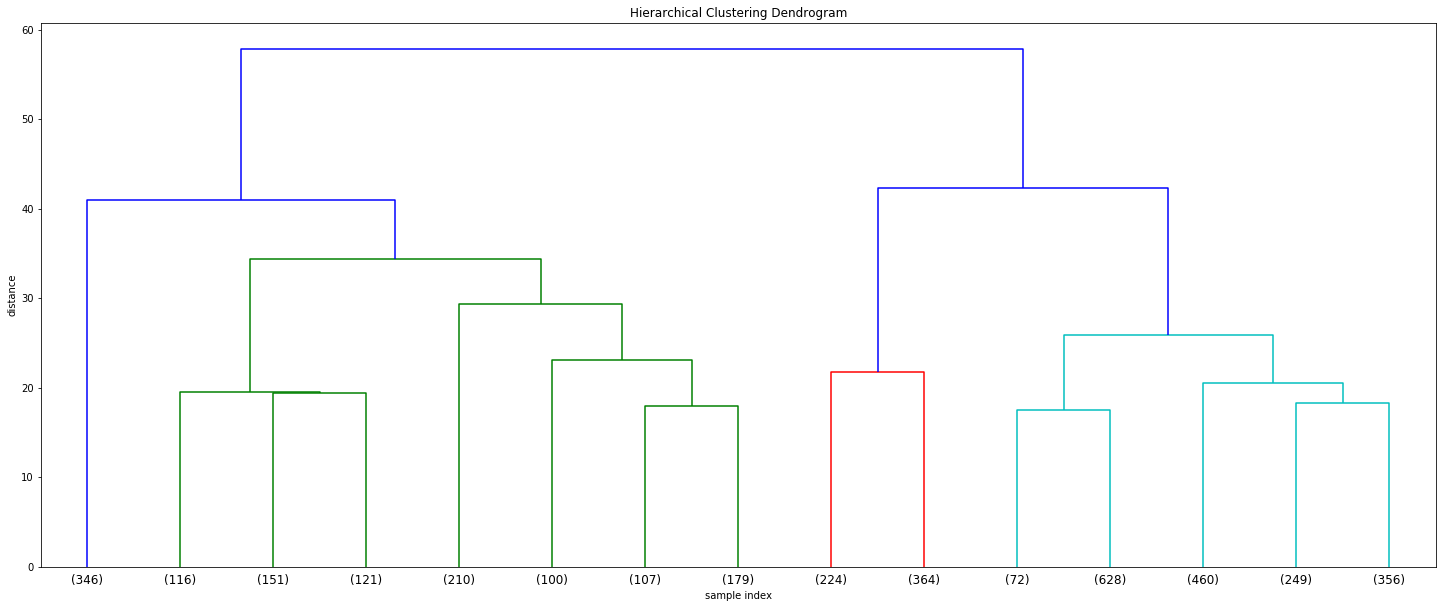

In [29]:
# calculate full dendrogram
Z=linkage(onehot_klinisch_nietspoed,'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z,truncate_mode='lastp',p=15)
plt.show()

#### Evaluation metrics of Clustering

In [41]:
#Verschillende methodieken tegen elkaar afwegen (gegevens feit dat we echt classes niet kennen): voor beiden geldt hoe hoger de waarde in principe hoe beter de clustering
print(metrics.silhouette_score(onehot_klinisch_spoed, klinisch_spoed['kmeans cluster nr'], metric='euclidean'))
print(metrics.silhouette_score(onehot_klinisch_spoed, klinisch_spoed['spectral cluster nr'], metric='euclidean'))
print(metrics.silhouette_score(onehot_klinisch_spoed, klinisch_spoed['agglomerative cluster nr'], metric='euclidean'))
print(metrics.silhouette_score(onehot_klinisch_spoed, klinisch_spoed['dbscan cluster nr'], metric='euclidean'))

print(metrics.calinski_harabaz_score(onehot_klinisch_spoed,klinisch_spoed['kmeans cluster nr']))
print(metrics.calinski_harabaz_score(onehot_klinisch_spoed,klinisch_spoed['spectral cluster nr']))
print(metrics.calinski_harabaz_score(onehot_klinisch_spoed,klinisch_spoed['agglomerative cluster nr']))
print(metrics.calinski_harabaz_score(onehot_klinisch_spoed,klinisch_spoed['dbscan cluster nr']))

0.0957560310497415
0.04798055494888715
0.08563000460160126
0.023744498347032725
98.11916169220262
60.423374046472425
74.89249112715477
47.63080185241702


In [42]:
print(metrics.silhouette_score(onehot_klinisch_nietspoed, klinisch_nietspoed['kmeans cluster nr'], metric='euclidean'))
print(metrics.silhouette_score(onehot_klinisch_nietspoed, klinisch_nietspoed['spectral cluster nr'], metric='euclidean'))
print(metrics.silhouette_score(onehot_klinisch_nietspoed, klinisch_nietspoed['agglomerative cluster nr'], metric='euclidean'))
print(metrics.silhouette_score(onehot_klinisch_nietspoed, klinisch_nietspoed['dbscan cluster nr'], metric='euclidean'))

print(metrics.calinski_harabaz_score(onehot_klinisch_nietspoed,klinisch_nietspoed['kmeans cluster nr']))
print(metrics.calinski_harabaz_score(onehot_klinisch_nietspoed,klinisch_nietspoed['spectral cluster nr']))
print(metrics.calinski_harabaz_score(onehot_klinisch_nietspoed,klinisch_nietspoed['agglomerative cluster nr']))
print(metrics.calinski_harabaz_score(onehot_klinisch_nietspoed,klinisch_nietspoed['dbscan cluster nr']))

0.14602416358062678
0.034519133466839554
0.12150803318283657
-0.0025601798591191123
382.36747845975964
190.13922609247922
298.08502478148233
97.22229301926568


#### Writing results to file

In [43]:
#Export to Excelfiles
def wegschrijvenclustering(dataframe,naam):
    writer = pd.ExcelWriter(pad+'\\'+naam+'.xlsx')
    dataframe.to_excel(writer,'data',index=False)
    writer.save()
    return

wegschrijvenclustering(klinisch_spoed,'clustered_spoed')
wegschrijvenclustering(klinisch_nietspoed,'clustered_nietspoed')